### **ANÁLISIS DE DATOS**  
En el siguiente documento se analizarán las variables numericas y categóricas que cuenta Bio organics SAS.

In [1]:
import pandas as pd
file_t = 'C:/Users/DANIEL LOPEZ/Documents/Escritorio/Escritorio/4 SEMESTRE/NTF/NTF FINAL/base de datos bio organics sas.xlsx'

data = pd.read_excel(file_t,sheet_name='Hoja1')
sr = pd.read_excel(file_t,sheet_name ='Hoja2')

sr = sr.drop(['Unnamed: 3'],axis=1)
sr = sr.drop(['Unnamed: 4'],axis=1)
sr.head(5)

,FECHA,VALOR,CLIENTE
0,2020-07-01,4000000,ALPINA
1,2020-07-02,4500000,JOSÉ ORDOÑES
2,2020-07-03,6000000,COSECHAS
3,2020-07-07,5400000,JOSÉ ORDOÑES
4,2020-07-07,6000000,SURTIFRUVER SAS


Inicialmente se propone hacer un analisis de series de tiempo y as un anaisis predictivo con el fin de evaluar el comportamiento futuro de la empresa.

Una serie de tiempo es una seuencia de valores ordenados en el tiempo. generalmente son mediciones de una misma variable o sucesos que pasaron en determinado momento del tiempo


Text(0.5, 1.0, 'INGRESOS BIO ORGANICS')

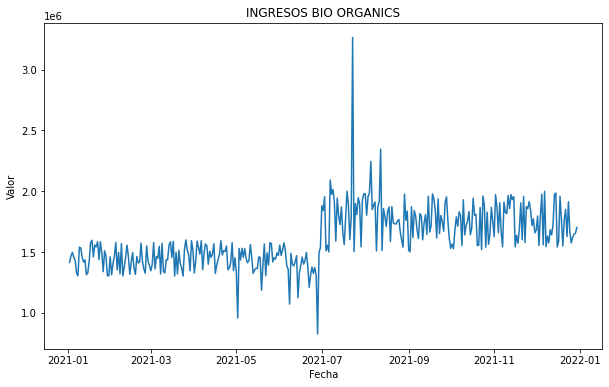

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sr['FECHA'] = pd.to_datetime(sr['FECHA'])
sr = sr[sr['FECHA']>pd.to_datetime('2021-01-01')]
plt.figure(figsize=(10,6))
plt.plot(sr.FECHA,sr.VALOR)
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('INGRESOS BIO ORGANICS')

Se observan datos atipicos que hacen que el conjunto de datos tenga ruidos o saturación. una posible solucion al problema es hacer ventanas de timpo diferentes ya que manejamos diferentes ventas de tiempo. En el caso de los datos contamos con un volumen opequeño en la cantidad de datos, por lo tanto se propone eliminar los valores faltantes para luego interpolar la serie de tiempo.

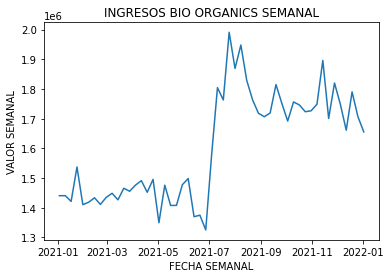

In [3]:
semanal = sr.resample('W', on ='FECHA').mean()
plt.plot(semanal.index,semanal.VALOR)
plt.xlabel('FECHA SEMANAL')
plt.ylabel('VALOR SEMANAL')
plt.title('INGRESOS BIO ORGANICS SEMANAL')
plt.show()

Como se mensiona anteriormente, no contamos con la suficiente cantidad de datos para poder hacer ventanas de tiempo.  
**ESTACIONALIDAD:** Es aquella rama de las series de tiempo que nos indica que los prcesos tienen comportamientos repetitivos a lo largo del tiempo .  
En este caso por el volumen de datos encontramos mayor estacionalidad de los datos en la ventada días.  
#### **VALORES ATIPICOS**  
Las anomalias son valores atipicos que se pueden encontrar en el set de datos. Estos son valores que se alejan bastande de la media. Saber detectarlas nos ayudará a detectas las componentes de la serie temporal, como lo son tendencia y estacionalidad.



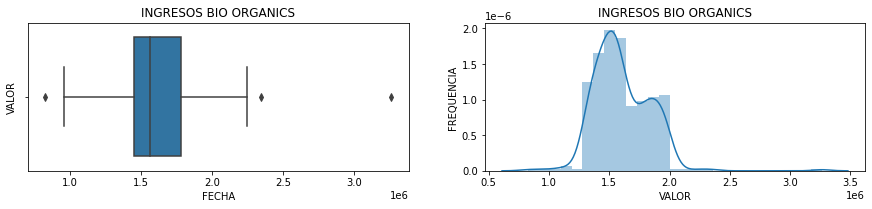

In [4]:
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(15,6))
plt.subplot(2,2,1)
sns.boxplot(sr['VALOR'])
plt.xlabel('FECHA')
plt.ylabel('VALOR')
plt.title('INGRESOS BIO ORGANICS')
plt.subplot(2,2,2)
sns.distplot(sr.VALOR)
plt.xlabel('VALOR')
plt.ylabel('FREQUENCIA')
plt.title('INGRESOS BIO ORGANICS')
plt.show()

Se observan valores atipicos a la derecha  y a la izquierda sobre la media, se propone separar los valores atipicos de los datos, para deteminar que no sea un error o haya un fraude financiero en los datos. Se pretenden eliminar así para encontra mayor estacionalidad y tendencia en los datos

In [5]:
print('VALOR MAXIMO', sr.VALOR.max())
print('VALOR MINIMO', sr.VALOR.min())
print('VALOR PROMEDIO', sr.VALOR.mean())

VALOR MAXIMO 3264705
VALOR MINIMO 825524
VALOR PROMEDIO 1605270.5757575757


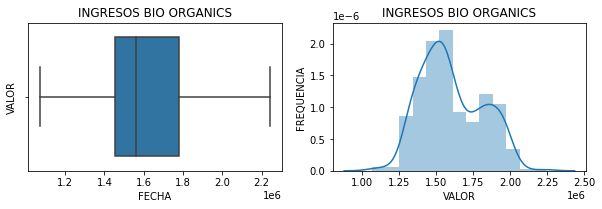

In [6]:
import numpy as np
sr.VALOR[sr.VALOR > 2300000] = np.nan
sr.VALOR[sr.VALOR < 1000000] = np.nan
import warnings
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
sns.boxplot(sr['VALOR'])
plt.xlabel('FECHA')
plt.ylabel('VALOR')
plt.title('INGRESOS BIO ORGANICS')
plt.subplot(2,2,2)
sns.distplot(sr.VALOR)
plt.xlabel('VALOR')
plt.ylabel('FREQUENCIA')
plt.title('INGRESOS BIO ORGANICS')
plt.show()

Se logran eliminar la mayoria de valores atipicos, con el fin de detectar las componentes y facilitar un modelo de predicción.  
se pretende ahora **interpolar** los datos faltantes que basicamente consiste en hallar un dato dentro de un intervalo que conozcamos los valores extremos.

In [7]:
diario = sr.resample('D', on ='FECHA').mean()
diario = diario.interpolate()
print(diario.isna().sum())
diario.head()

VALOR    0
dtype: int64


,VALOR
FECHA,
2021-01-02,1414500.0
2021-01-03,1466847.0
2021-01-04,1496537.0
2021-01-05,1456395.0
2021-01-06,1431432.0


### COMPONENTES DE LA SERIE  
La obtencin de la serie de tiempo depende del problema. La mayoria de las series temporales se comportan como **TENDENCIA + ESTACIONALIDAD * ESTACIONALIAD +  RUIDO.  
  
Uno de los métodos para sacar la estacionalidad se llama media movil, consiste en tomar una ventana de tiempo suficientemente grande para promediar la serie sobre esa ventana. de esa forma se obtendria la tendencia de los datos.  
Otra forma, es ajsutar una regresion lineal a la serie temporal y se observaría el comportamiento de la tendencia de los datos

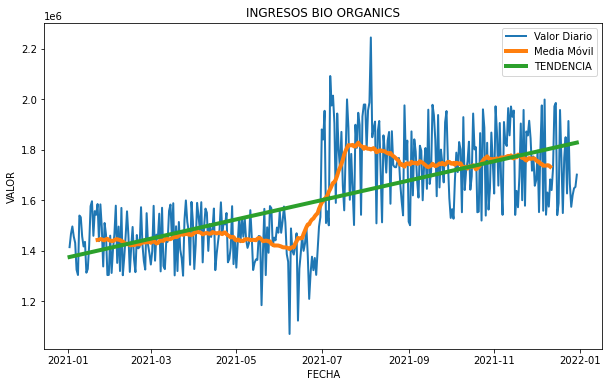

In [8]:
import datetime
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
ventana = int(40)
media_movil = diario.rolling(window=ventana,center=True).mean()
diario['FECHA_NUMEROS'] = diario.index.map(datetime.datetime.toordinal)
lr.fit(diario.FECHA_NUMEROS.values.reshape(-1,1),diario.VALOR.values.reshape(-1,1))
plt.figure(figsize=(10,6))
plt.plot(diario.index,diario.VALOR,lw=2,label='Valor Diario')
plt.plot(media_movil.index,media_movil.VALOR,lw=4,label='Media Móvil')
plt.plot(diario.index,lr.predict(diario.FECHA_NUMEROS.values.reshape(-1,1)),lw=4,label='TENDENCIA')
plt.xlabel('FECHA')
plt.ylabel('VALOR')
plt.title('INGRESOS BIO ORGANICS')
plt.legend()
plt.show()

Se puede observar que hay un crecimiento alsisra aunque en los ultimo siempre hay un estancamiento en los datos.  
**Ruido blanco**  
El ruido blanco es una secuencia de variables aleatorias no correlacionadas , que sigues una misma distribución con igual media (generalmente 0), varianza constante y covarianza 0. Esta suele ser la componente que no se le hara una predicción .


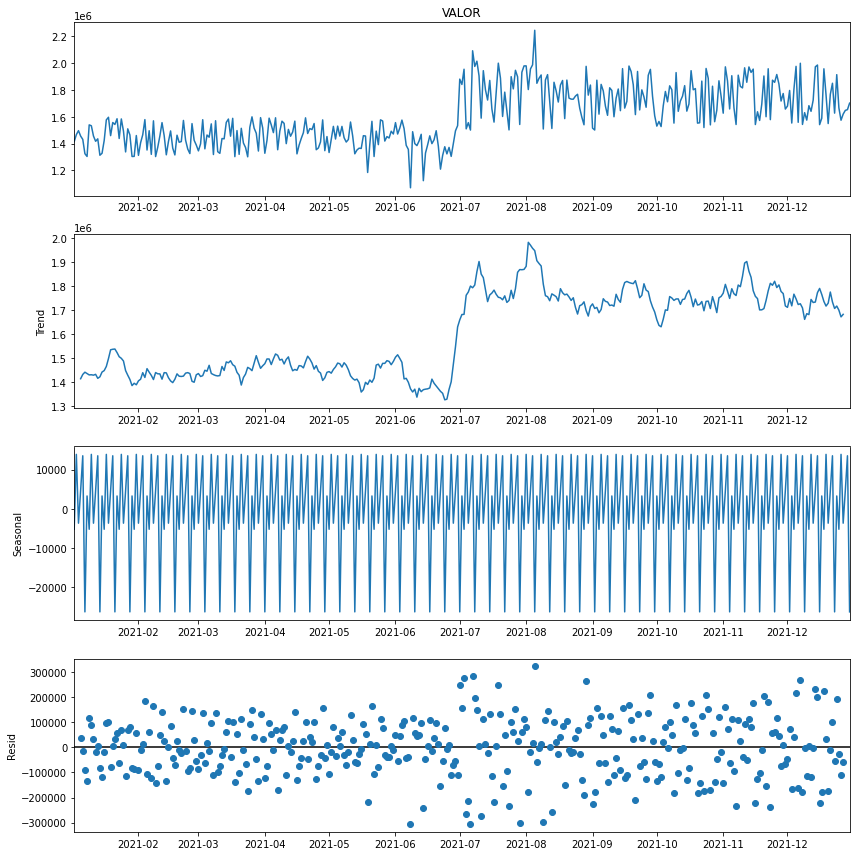

In [9]:
import matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(diario.VALOR, model='additive')
matplotlib.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

### AUTOCORRELACIÓN  
La correlación es una cuantificación de la relación entre ek comportamiento de dos variabes. En las series de tiempo el termino de correlación en series de tiempo es una correlación entre ella misma, aca aparee un cocepto llamados lags. Estos buscan ver cuantos suceso se repiten en una ventana de tiempo.  
#### **METODOLOGÍA BOX JENKINS**  
Analizar los correlogramas ( Función de autocorrelación y autocorrelación parcial)  
Test de Dicky-Fuller.  
Existen formas para transformar una serie estacional las cuales se aplicaran el modelo:  
+ La diferencia (Resta la variable z = (yt -(yt-1))
+ Transformación logaritmica  
+ La diferencia del logaritmo  
Sarima predice todo lo que de forma lineal, se puede utilizar el pasado para explicar el futuro

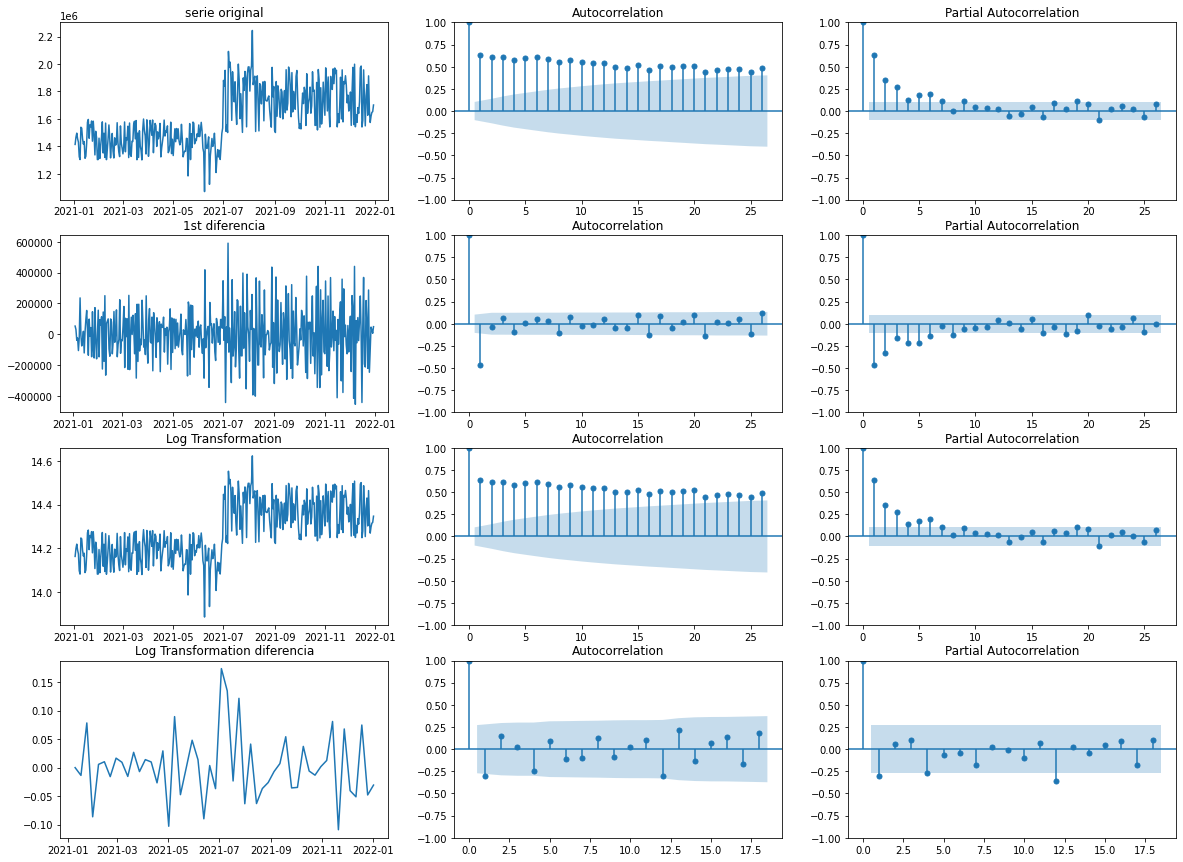

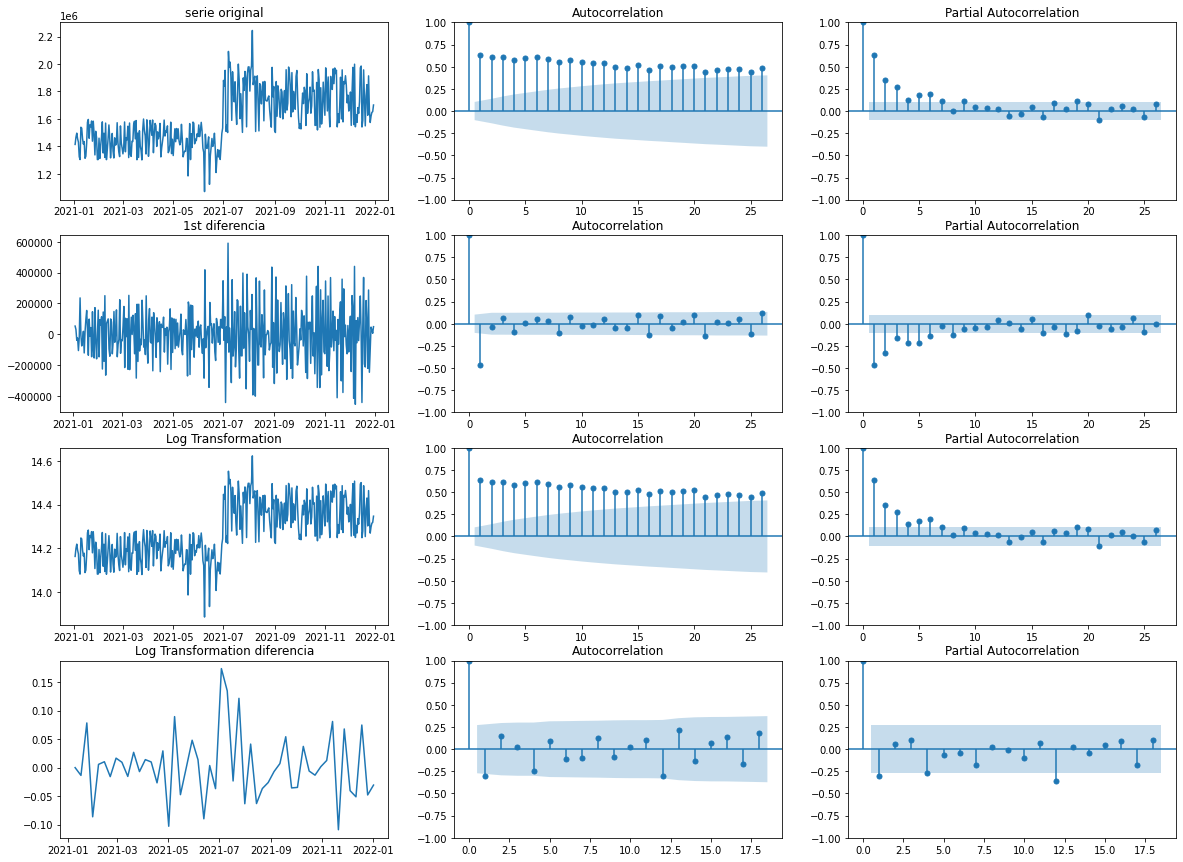

In [10]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig, axes = plt.subplots(4,3,figsize = (20,15))
axes[0,0].plot(diario.VALOR);axes[0,0].set_title('serie original')
plot_acf(diario.VALOR, ax = axes[0,1])
plot_pacf(diario.VALOR, ax = axes[0,2])

axes[1,0].plot(diario.VALOR.diff()); axes[1,0].set_title('1st diferencia')
plot_acf(diario.VALOR.diff().dropna(), ax = axes[1,1])
plot_pacf(diario.VALOR.diff().dropna(), ax = axes[1,2])

axes[2,0].plot(np.log(diario.VALOR)); axes[2,0].set_title('Log Transformation')
plot_acf(np.log(diario.VALOR).dropna(),ax = axes[2,1])
plot_pacf(np.log(diario.VALOR).dropna(),ax = axes[2,2])

axes[3,0].plot(np.log(semanal.VALOR).diff()); axes[3,0].set_title('Log Transformation diferencia')
plot_acf(np.log(semanal.VALOR).diff().dropna(),ax = axes[3,1])
plot_pacf(np.log(semanal.VALOR).diff().dropna(),ax = axes[3,2])

Necesitamos hayar el parametro P, que es de la parte regresova y el parametreo Q de media movil, para eso tenemos que buscar los retardos que más se salgan del intervalo de confianza, ya que permite saber cual es el mejor periodo de tiempo para explicar el futuro.  
para los procesosa autorregresivos se usa la autocorrelación parcial y procesos de media movi la autocorrelación.  
Lo que diferencia Arma de Arima son las diferencias que se le efectuan, para luego aplicar el modelo arma.  
  
#### numero de diferencias que necesito con el test de diky fuller

In [11]:
from pmdarima.arima.utils import ndiffs
print(ndiffs(diario.VALOR,test='adf'))

1


In [12]:
diffClose = diario.VALOR.diff()
print(ndiffs(diffClose[1:],test = 'adf'))

0


El método diky fuller nos hace la comprobación que necesitamos una diferencia, ahí se observa una mayor estacionalidad y ocilación en el rango 0

## Modelo arima que más se ajusta a las autocorrelaciones encontradas

Se escoje el parametro 20 ya que es el que más se sale del intervalo de confianza de la autocorrelación

In [13]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(diario.VALOR, order=(10,1,8))
# el orden de los parameteos es p d q
model_fit = model.fit()
print(model_fit.summary())

C:\Users\DANIEL LOPEZ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  VALOR   No. Observations:                  363
Model:                ARIMA(10, 1, 8)   Log Likelihood               -4808.635
Date:                Sat, 06 Nov 2021   AIC                           9655.270
Time:                        07:27:36   BIC                           9729.211
Sample:                    01-02-2021   HQIC                          9684.664
                         - 12-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3591      0.125     -2.867      0.004      -0.605      -0.114
ar.L2          0.2584      0.145      1.786      0.074      -0.025       0.542
ar.L3         -0.0216      0.112     -0.192      0.8

* Se observa que en el reporte el valor abosuto del z  es mayor que 1.96 lo cual hace que sean relevantes los valores ya que hablamos de dos distribuciones estandar. El L5 y el L6 son los menos relevantes
* P>|z| la mayoria de valores son menores a 0.05 lo cual hace que sea un parametro relevante.
* El rango del intervalo de confianza desde 0.025 y 0.975 y solo el parametro son relevantes ya que esta dentro de su rango el 0  

### Residuos 


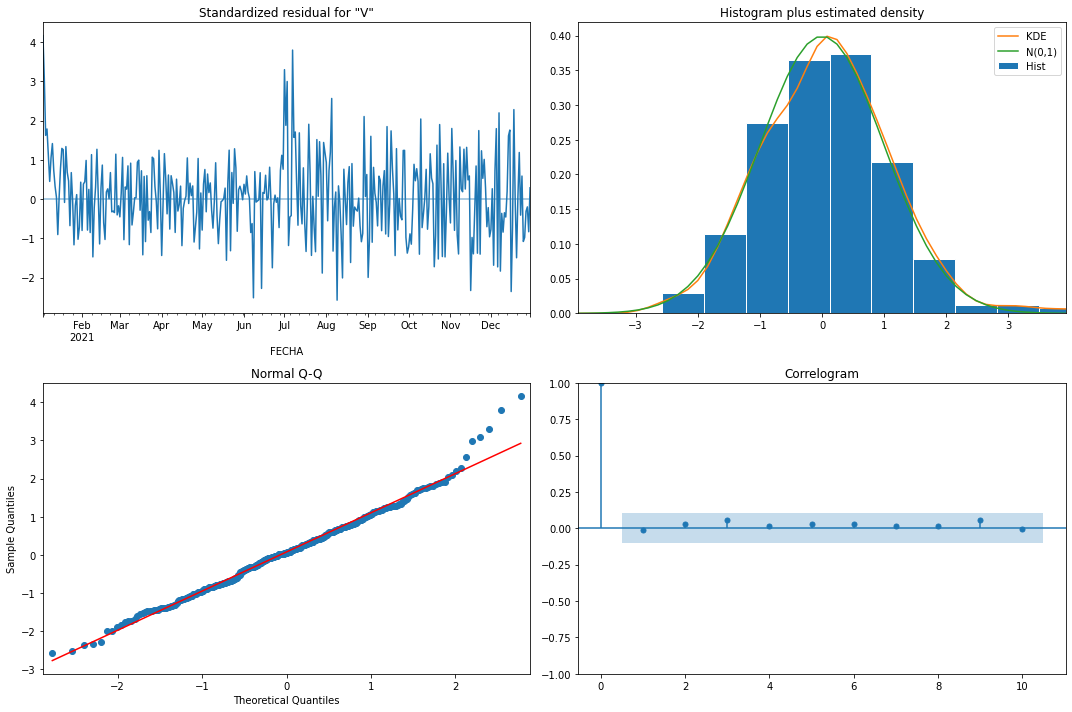

In [14]:
model_fit.plot_diagnostics(figsize=(15,10))
plt.tight_layout()
plt.show()

* En el primer gráfico buscamos ruido blanco, aunque no tenga media 0 y la varianza no sea constante pero oscila en 0 
* En el segundo vemos que los errores no se estan distribuyendo normalmente ya que no tiene media 0 como la linea verde, sin embargo se asemejan bastande a la linea deseada
* En el mayor de los casos los puntos azules (Errores) se ajustan a la linea roja
* Hay variables que se encuentran dentro de el intervalo de confianza

### Pronostico


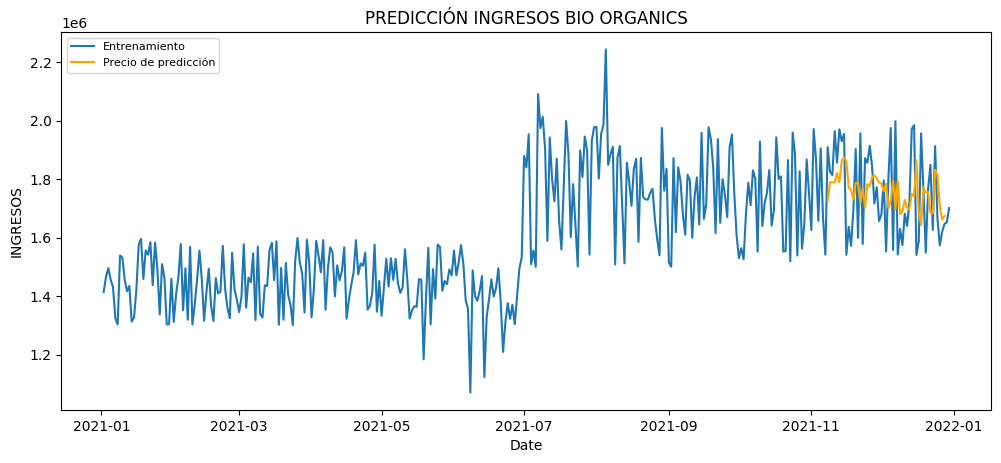

In [15]:
fc = model_fit.predict(start = 310,end= 360)
fc_series = pd.Series(fc)
plt.figure(figsize=(12,5),dpi = 100)
plt.plot(diario.VALOR,label = 'Entrenamiento')
plt.plot(fc_series, color = 'orange', label = 'Precio de predicción')
plt.title('PREDICCIÓN INGRESOS BIO ORGANICS')
plt.xlabel('Date')
plt.ylabel('INGRESOS')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

Haciendo una prediccicción sobre el mismo muestreo se observa que aunque puede seguir un patron de la serie no cubre todos los valores predichos, se podría intentar con un modelo de machine learning para probar resultados

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import math
test_data = diario.VALOR[310:360]

mse = mean_squared_error,(test_data,fc)
#print('MSE'+str(mse))
mae = mean_absolute_error,(test_data,fc)
#print('MAE'+str(mae))
#rmse = math.sqrt(mean_squared_error(test_data,fc))
#print('RMSE'+ str(rmse))
mape = np.mean(np.abs(fc-test_data)/np.abs(test_data))
#print('MAPE'+ str(mape))
R2 = r2_score,(test_data,fc)
print('R2'+ str(R2))

R2(<function r2_score at 0x0000025DABED9700>, (FECHA
2021-11-08    1909910.0
2021-11-09    1826277.0
2021-11-10    1814896.0
2021-11-11    1964833.0
2021-11-12    1857036.0
2021-11-13    1971250.0
2021-11-14    1930678.0
2021-11-15    1955201.0
2021-11-16    1542099.0
2021-11-17    1637248.0
2021-11-18    1572564.0
2021-11-19    1694396.0
2021-11-20    1903883.0
2021-11-21    1600294.0
2021-11-22    1957618.0
2021-11-23    1578532.0
2021-11-24    1872597.0
2021-11-25    1856479.0
2021-11-26    1914857.0
2021-11-27    1845008.0
2021-11-28    1717226.0
2021-11-29    1773283.0
2021-11-30    1657424.0
2021-12-01    1679867.0
2021-12-02    1796060.0
2021-12-03    1553201.0
2021-12-04    1803435.0
2021-12-05    1975603.0
2021-12-06    1558684.0
2021-12-07    1998786.0
2021-12-08    1542837.0
2021-12-09    1630772.0
2021-12-10    1575039.0
2021-12-11    1682645.0
2021-12-12    1640602.0
2021-12-13    1724541.0
2021-12-14    1972270.0
2021-12-15    1985408.0
2021-12-16    1541321.0
2021-12-17 

Se observan valores muy lejos de la realidad, y se optaria por el proceso de prophet.  
sin embargo se podrían mejorar los parametros con un autoarima

## Autoarima

In [17]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(diario.VALOR)

(0.10630310937010162, True)

Podemos interpretar que los datos son estacionarios por lo que se procedera a construir el nodelo auto arima 

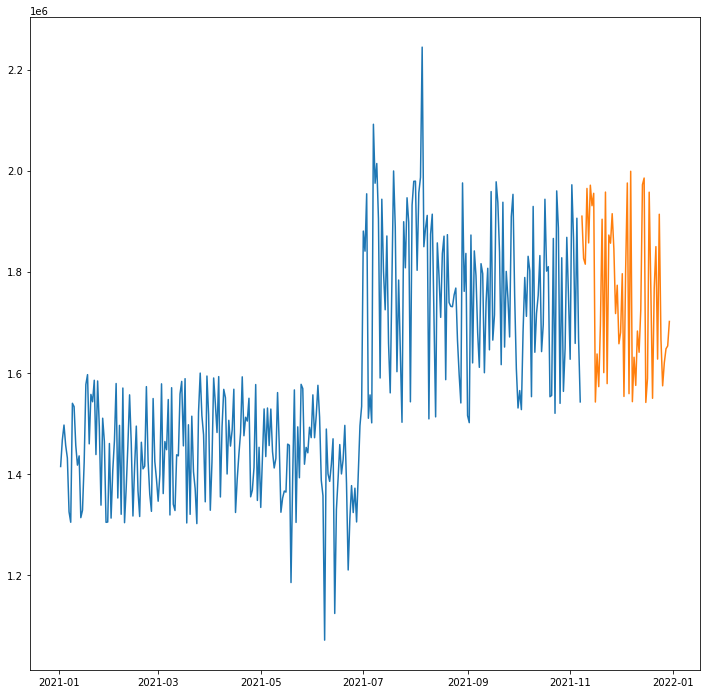

In [18]:
len(diario)
train = diario[:310]
train = train.drop(columns=['FECHA_NUMEROS'])
test = diario[-53:]
test = test.drop(columns=['FECHA_NUMEROS'])
plt.plot(train)
plt.plot(test)

plt.show()

Aquí, estamos probando con los valores p, d, q que van de 0 a 20 para obtener mejores valores óptimos del modelo

In [19]:
from pmdarima.arima import auto_arima
auto_arima = auto_arima(train, start_p = 0,d=1,start_q = 0,
                       max_p = 30,max_d = 10,max_q = 30)

In [20]:
print(auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  310
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4105.550
Date:                Sat, 06 Nov 2021   AIC                           8217.100
Time:                        07:27:40   BIC                           8228.300
Sample:                             0   HQIC                          8221.578
                                - 310                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1631      0.045      3.666      0.000       0.076       0.250
ma.L1         -0.8205      0.034    -24.080      0.000      -0.887      -0.754
sigma2       2.01e+10   5.27e-13   3.82e+22      0.0

Si comparamos el AIC con el primer modelo arima, el segundo nos ofrece mejor relevancia de los parametros

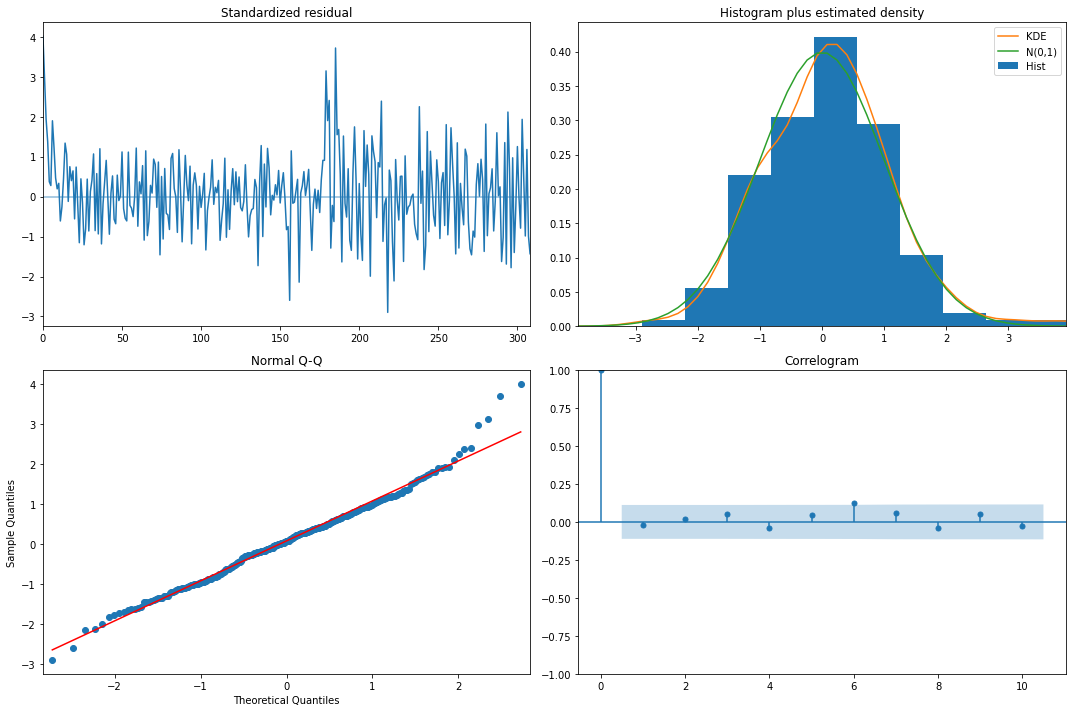

In [21]:
auto_arima.plot_diagnostics(figsize=(15,10))
plt.tight_layout()
plt.show()

Los errorres se nos comportan de una mejor forma en comparación del primer modelo de Arima, la distribción se asemeja más y el correlograma tiene los puntos en los intervalos de confianza

In [22]:
predes_  = pd.DataFrame(auto_arima.predict(n_periods=53), index=test.index)
predes_.columns = ['Pres']
predes_.head()

,Pres
FECHA,
2021-11-08,1.688176e+06
2021-11-09,1.711957e+06
2021-11-10,1.715837e+06
2021-11-11,1.716470e+06
2021-11-12,1.716573e+06


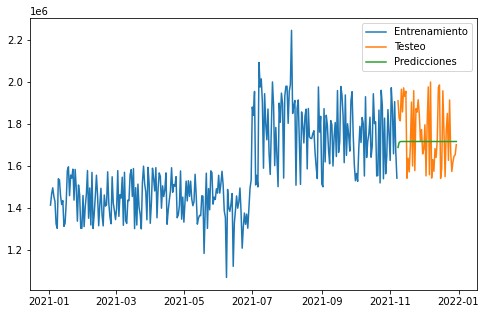

In [23]:
plt.figure(figsize=(8,5))
plt.plot(train, label = 'Entrenamiento')
plt.plot(test,label = 'Testeo')
plt.plot(predes_,label = 'Predicciones')
plt.legend()
plt.show()

El modelo Arima no predice la cantidad de datos que deberia

## Machine Learning  
Se propone entrenar un Random forest regressor y un XGBOOST regressor con el fin de predecir el futuro de la serie de tiempo

In [24]:
look_back = 53
diario.drop(columns=['FECHA_NUMEROS'], inplace=True)

In [25]:
ing = diario.VALOR
ing.head()

FECHA
2021-01-02    1414500.0
2021-01-03    1466847.0
2021-01-04    1496537.0
2021-01-05    1456395.0
2021-01-06    1431432.0
Freq: D, Name: VALOR, dtype: float64

Para aplicar un modelo de machine learning primero se tendra quetransformar la data de tal forma de hacer una división de los datos de entrenamiento y testeo

In [26]:
N = ing.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)
for i in range(X.shape[0]):
    #X[i,:] = diario.values.iloc[i:i+look_back
    #y[i] = diario.values.iloc[i+look_back]

    X[i,:] = ing.iloc[i:i+look_back]
    y[i] = ing.iloc[i+look_back]


N_train = 310- look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test =  53#cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)


(309, 53) (309,)
(257, 53) (257,)
(52, 53) (52,)


In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs = 4).fit(X_train,y_train)

In [28]:
d=ing.index[N_train+look_back: length_total]
d = d[0:52]



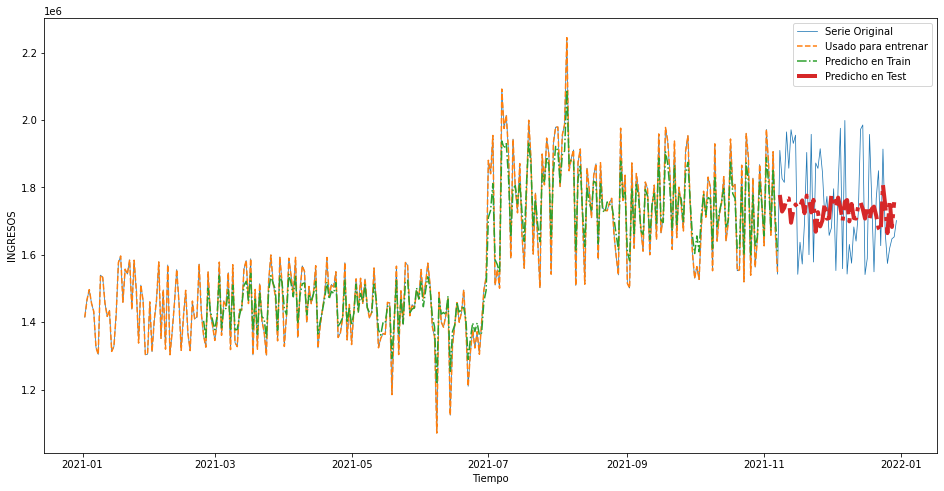

In [29]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
plt.figure(figsize=(16,8))
plt.plot(ing.index[:length_total], ing[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(ing.index[:N_train + look_back], ing[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(ing.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(d.values,y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('INGRESOS')
plt.show()

In [30]:
print(r2_score(y_train,y_train_pred))
print(r2_score(y_test,y_test_pred))

0.9357148898727954
-0.02997580099992958


El modelo se entrena muy bien pero se ajusta a los datos de entenamiento hacieto que se vuelva un modeo que predice mal el futuro

In [31]:
import xgboost as xgb
import scipy as sp
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
model_boost = XGBRegressor()
param = {'n_estimators':sp.stats.randint(1, 500)}
xgboostre = RandomizedSearchCV(model_boost, param,n_iter=500, random_state=0, cv=5)
xgboostre.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predicto

In [32]:
print("Mejores parametros: "+str(xgboostre.best_params_))
print("Mejor Score: "+str(xgboostre.best_score_)+'\n')

Mejores parametros: {'n_estimators': 17}
Mejor Score: -0.6955142836490353



El modelo no se ajusta lo sufiviente a los datos, no genera una predicción correcta en el futuro ya que el modelo genera overfiting.

### DEEP LEARNING

In [33]:
diario_red = diario.reset_index()
diario_red.head(4)

,FECHA,VALOR
0,2021-01-02,1414500.0
1,2021-01-03,1466847.0
2,2021-01-04,1496537.0
3,2021-01-05,1456395.0


In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout, Flatten


PASOS=8
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else diario.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
values = diario.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()


,var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
8,-0.414390,-0.325185,-0.274591,-0.342997,-0.385536,-0.567296,-0.602411,-0.201189,-0.212492
9,-0.325185,-0.274591,-0.342997,-0.385536,-0.567296,-0.602411,-0.201189,-0.212492,-0.343080
10,-0.274591,-0.342997,-0.385536,-0.567296,-0.602411,-0.201189,-0.212492,-0.343080,-0.409761
11,-0.342997,-0.385536,-0.567296,-0.602411,-0.201189,-0.212492,-0.343080,-0.409761,-0.378552
12,-0.385536,-0.567296,-0.602411,-0.201189,-0.212492,-0.343080,-0.409761,-0.378552,-0.586793


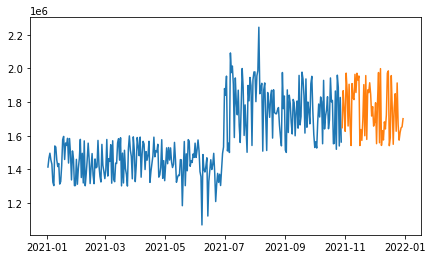

In [35]:

set_entrenamiento = diario.iloc[:300]
set_testeo = diario.iloc[-63:]
plt.figure(figsize=(7,4))
plt.plot(set_entrenamiento)
plt.plot(set_testeo)
plt.show()


Lo que se hizo fue transformar por ventanas y normalizar los datos que contabamos

subdividiremos nuestro conjunto de datos en train y en test. Por lo tanto, haremos una subdivisión de los primeros 826 días consecutivos para entrenamiento de la red y los siguientes 262 para su validación.

In [36]:
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)
time_step = 8
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)
for i in range(time_step,m):
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
#################################################

x_test = set_testeo.values
x_test = sc.transform(x_test)
X_test = []
Y_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [37]:
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 100
model = Sequential()
model.add(LSTM(units = na, input_shape= dim_entrada))
model.add(Dense(200, activation='relu'))
model.add(Dense(150, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(50, activation='tanh'))
model.add(Dense(20, activation='relu'))
model.add(Dense(units = dim_salida))
model.compile(optimizer = 'rmsprop', loss = 'mse')
model.fit(X_train,Y_train, epochs= 10000,batch_size = 32)

Epoch 1/10000
10/10 [==============================] - 3s 9ms/step - loss: 0.0596
Epoch 2/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0183
Epoch 3/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.0176
Epoch 4/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.0199
Epoch 5/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.0158
Epoch 6/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.0244
Epoch 7/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.0167
Epoch 8/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.0167
Epoch 9/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.0218
Epoch 10/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.0199
Epoch 11/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.0189
Epoch 12/10000
10/10 [==============================] - 0s 5ms/step - loss: 0.0181
Epoch 13/1000

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 200)               20200     
_________________________________________________________________
dense_1 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2

Se crea un modelo de redes neuronales recurrentes con aproximamadamente 112341 parametros con el fin de poder predecir el comportamiento fururo de los ingresos de bio organics

r2 del entrenamiento de la red neuronal 0.9991434724400484
r2 del testeo de la red neuronal -2.9545240331080804


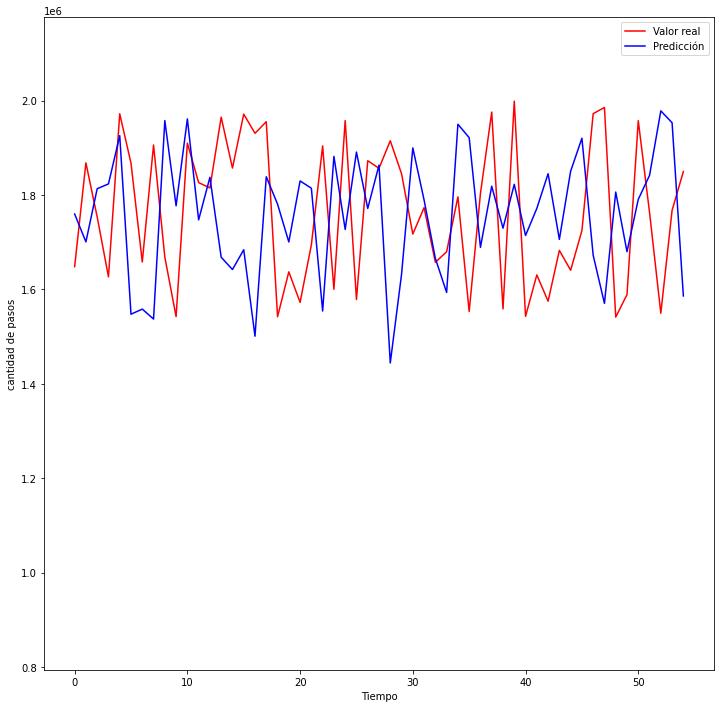

In [39]:
prediccion = model.predict(X_test)
prediccion_r = scaler.inverse_transform(prediccion) 
print('r2 del entrenamiento de la red neuronal',r2_score(Y_train,model.predict(X_train)))
print('r2 del testeo de la red neuronal',r2_score(np.array(set_testeo)[0:len(prediccion)],prediccion_r.reshape(-1,1)))
prediccion = sc.inverse_transform(prediccion)
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real')
    plt.plot(prediccion, color='blue', label='Predicción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('cantidad de pasos')
    plt.legend()
    plt.show()
graficar_predicciones(set_testeo.values,prediccion)

Al ser un modelo avanzado, tiende a sobreajustar y atener malas predicciones de los datos en el futuro, se propone recolectar mayor volumen de datos para asi tener una mejor certidumbre

Se puede observar que al momento de usar redes neuronales se necesitan mayores volumenes de datos, es por lo cual que no se recomienda usar dicho modelo para esta situación.

### **Neural Prophet**  

 es un paquete desarrollado para mantener las mismas características que ya tiene Prophet: simplicidad de uso, posibilidad de añadir variables explicativas y fácil implementación.  

 Este modelo cuenta con, Método de gradiente descendente para optimización basado en *PyTorch* en lugar del paquete estadístico *Stan* que es base de *Prophet*.
- Modela la autocorrelación de series de tiempo usando redes autoregresivas (*AR-Net*).
- Modela los regresores rezagados usando una red neuronal separada.
- Tiene capas internas no lineales (de la red neuronal) que son configurables.
- Se puede ajustar a horizontes específicos de pronóstico.
- Pérdidas y métricas personalizadas.

In [40]:
from neuralprophet import NeuralProphet
diario_p = diario.reset_index()
diario_p.rename(columns={'FECHA':'ds','VALOR': 'y'}, inplace=True)
diario_p.head()

,ds,y
0,2021-01-02,1414500.0
1,2021-01-03,1466847.0
2,2021-01-04,1496537.0
3,2021-01-05,1456395.0
4,2021-01-06,1431432.0


Para poder transformar el modelo se necesita transformar el set de datos como se muestra

In [41]:
m = NeuralProphet(seasonality_mode='multiplicative')
metrics = m.fit(diario_p, freq="D")

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 232
 86%|████████▌ | 195/228 [00:00<00:00, 300.82it/s]
INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.15E-02, min: 4.58E-01
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 2.34E-01
Epoch[232/232]: 100%|██████████| 232/232 [00:07<00:00, 29.28it/s, SmoothL1Loss=0.0109, MAE=1.04e+5, MSE=1.72e+10, RegLoss=0]


In [42]:
metrics = m.fit(diario_p, freq="D")
future = m.make_future_dataframe(diario_p, periods=365, n_historic_predictions=len(diario_p))
forecast = m.predict(future)

WARNING - (NP.forecaster.fit) - Model has already been fitted. Re-fitting will produce different results.
Epoch[232/232]: 100%|██████████| 232/232 [00:07<00:00, 30.04it/s, SmoothL1Loss=0.0109, MAE=1.03e+5, MSE=1.72e+10, RegLoss=0]


r2 para modelo de prophet 0.5947896625756265


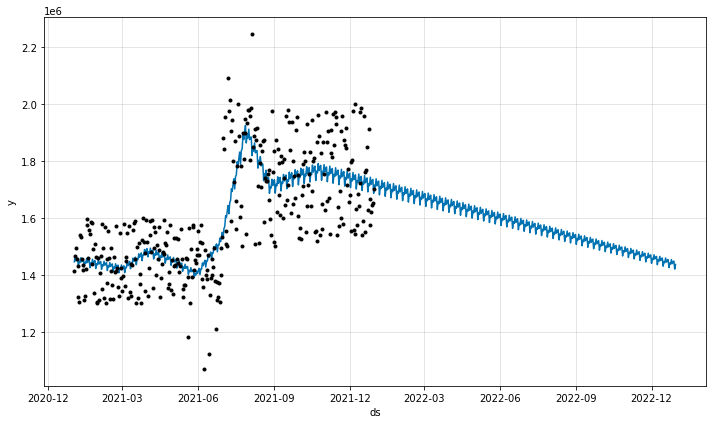

In [43]:
validation =forecast.dropna()
print('r2 para modelo de prophet',r2_score(validation['y'],validation['yhat1']))
forecasts_plot = m.plot(forecast)

El modelo es capaz de predecir la matori de los datos con acirto, comienza a verse un modelo que podría dar algo de certidumbre para el objetivo del trabajo

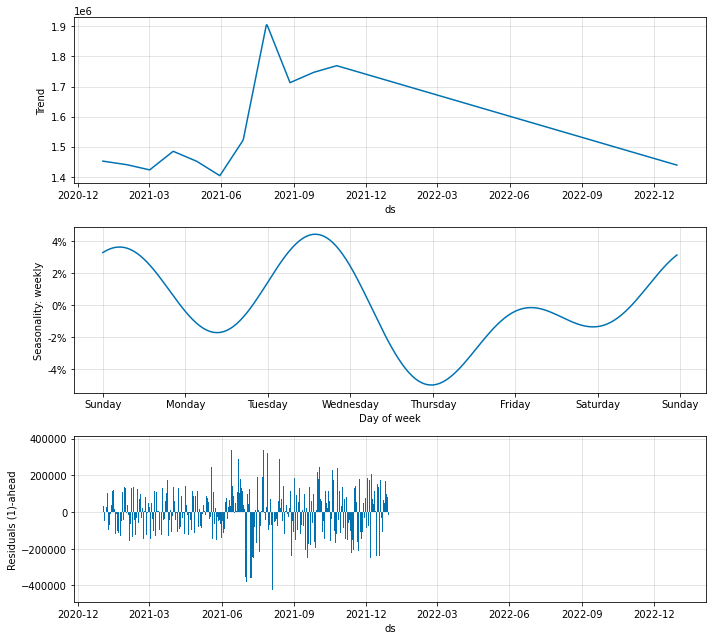

In [44]:
fig_comp = m.plot_components(forecast, residuals=True)

Se observa una tendencia negativa, el proximo año, se propone realizar modelos de segmentacion de clientes y regresion de variables para buscar la forma de incrementar los ingresos de la compañia

In [45]:
ts = diario_p.rename(columns={'ds':'ts','y': 'y'})

#### USANDO GREYLIKE  
Silverkite no hay una ecuación que represente el modelo predictivo. En su lugar, presentan un diagrama con los procesos que hace el algoritmo:  
- En un primer paso, extrae características que puedan influir en el modelo, como días feriados, tendencia estacionalidad.
- En segundo lugar, pasa dichas características a una base apropiada (como series de Fourier que también usa Prophet), para un modelo aditivo.
- En tercer lugar, Silverkite busca quiebres en la tendencia o en la estacionalidad.
- De las características extraídas en el segundo y tercer paso, busca un modelo de aprendizaje automático para explicar dichas variables.
- Y finalmente, de los residuales que quedan, busca un modelo de varianza condicional para capturar la volatilidad que aún persista.
- El usuario de Greykite, es decir, yo, puedo incluir variables explicativas o modificar los días feriados.

In [46]:
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results
metadata = MetadataParam(
    time_col=ts["ts"],  # name of the time column ("date" in example above)
    value_col=ts["y"],  # name of the value column ("sessions" in example above)
    freq="D")

forecaster = Forecaster()  # Creates forecasts and stores the result
result = forecaster.run_forecast_config(ts,config=ForecastConfig(forecast_horizon=365,coverage=0.95))

Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [47]:
grid_search = result.grid_search
cv_results = summarize_grid_search_results(
    grid_search=grid_search,
    decimals=2,
    # The below saves space in the printed output. Remove to show all available metrics and columns.
    cv_report_metrics=None,
    column_order=["rank", "mean_test", "split_test", "mean_train", "split_train", "mean_fit_time", "mean_score_time", "params"])
 # Transposes to save space in the printed output
cv_results["params"] = cv_results["params"].astype(str)
cv_results.set_index("params", drop=True, inplace=True)
cv_results.transpose()

params,[]
rank_test_MAPE,1
mean_test_MAPE,13.36
split_test_MAPE,"(13.74, 12.99)"
mean_train_MAPE,6.88
split_train_MAPE,"(5.16, 8.6)"
mean_fit_time,3.06
mean_score_time,0.46


In [48]:
import plotly
backtest = result.backtest
fig = backtest.plot()
plotly.io.show(fig)

Se puede observar que la mayoría de los datos entran en el intervalo de confianza. auqneu no predice con presicion no llena el intervalo de confianza

In [49]:
from collections import defaultdict
backtest_eval = defaultdict(list)
for metric, value in backtest.train_evaluation.items():
    backtest_eval[metric].append(value)
    backtest_eval[metric].append(backtest.test_evaluation[metric])
metrics = pd.DataFrame(backtest_eval, index=["train", "test"]).T
metrics

,train,test
CORR,0.708075,0.053963
R2,0.486601,-0.152322
MSE,20914263784.255547,26625251270.703484
RMSE,144617.646863,163172.458677
MAE,116489.014554,142673.840405
MedAE,101579.455063,152211.455593
MAPE,7.440166,8.416058
MedAPE,6.799616,8.525109
sMAPE,3.684933,4.078297
Q80,58244.507277,56248.6078


Aunque el modelo muestra que tiene un ajuste en los datos de entrenamiento, no es lo suficioentemente profundo para datos en el futuro.

In [50]:
 forecast = result.forecast
 fig = forecast.plot()
 plotly.io.show(fig)

Para los siguientes periodos se observa un comportamiento creciente, para esto se propone mirar las componentes de la serie temporal con  el fin de interpretar la tendencia de ella

In [51]:
 fig = forecast.plot_components()
 plotly.io.show(fig)

Los ingresos de la empresa muestran un comportamiento creciente, esto demuestra el crecimiento de la empresa y la efectividad de sus estrategias para estar más presente en el mercado

#### Regresiones   
para analizar un posible invremento en los ingresos, se propone hacer modelos de regresion y clasificación con el fin de tener merjores resuultados en el futuro

In [52]:
data.head()

,FECHA,INGRESOS,PUBLICIDAD,DIA SEM,TEMPERATURA,ESTRATO SOCIO ECONÓMICO,PRODUCTO,CLIENTE
0,2021-01-01,1335781,59621,6,13,4,MERMELADA DE FRESA,FRVER CANT
1,2021-01-02,1414500,117485,7,21,4,MERMELADA DE FRESA,COSECHAS
2,2021-01-03,1466847,169105,1,23,4,SALSA DE TOMATE,ALPINA
3,2021-01-04,1496537,159214,2,20,4,SALSA DE TOMATE,ALPINA
4,2021-01-05,1456395,159873,3,21,4,HARINA DE GARBANZO,ALPINA


#### Analisis exploratorio de datos

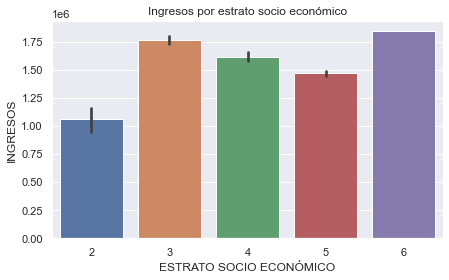

In [53]:
sns.set()
plt.figure(figsize=(7,4))
sns.barplot(x="ESTRATO SOCIO ECONÓMICO", y="INGRESOS", data=data)
plt.title("Ingresos por estrato socio económico")
plt.show()

Se puede observar que los estratos que más generan ingresos son los estratos 6 y 3, a partir de este se pueden ubicar sucursales de la empresa en estos sectores para generar cercania ante las personas.

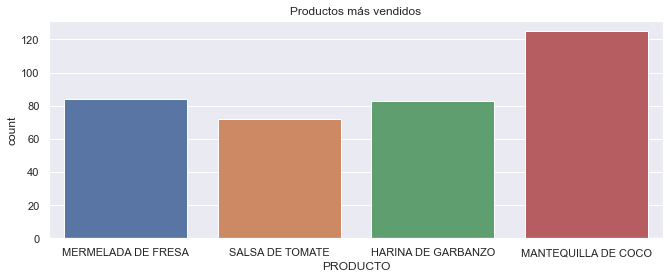

In [54]:
plt.figure(figsize=(11,4))
sns.countplot(x='PRODUCTO',data=data)
plt.title("Productos más vendidos")
plt.show()

El producto mas vendido es la mantequilla de coco, por consiguiende se pretende enfocar la publicidad en este producto para contarle a las personas los beneficios de este producto

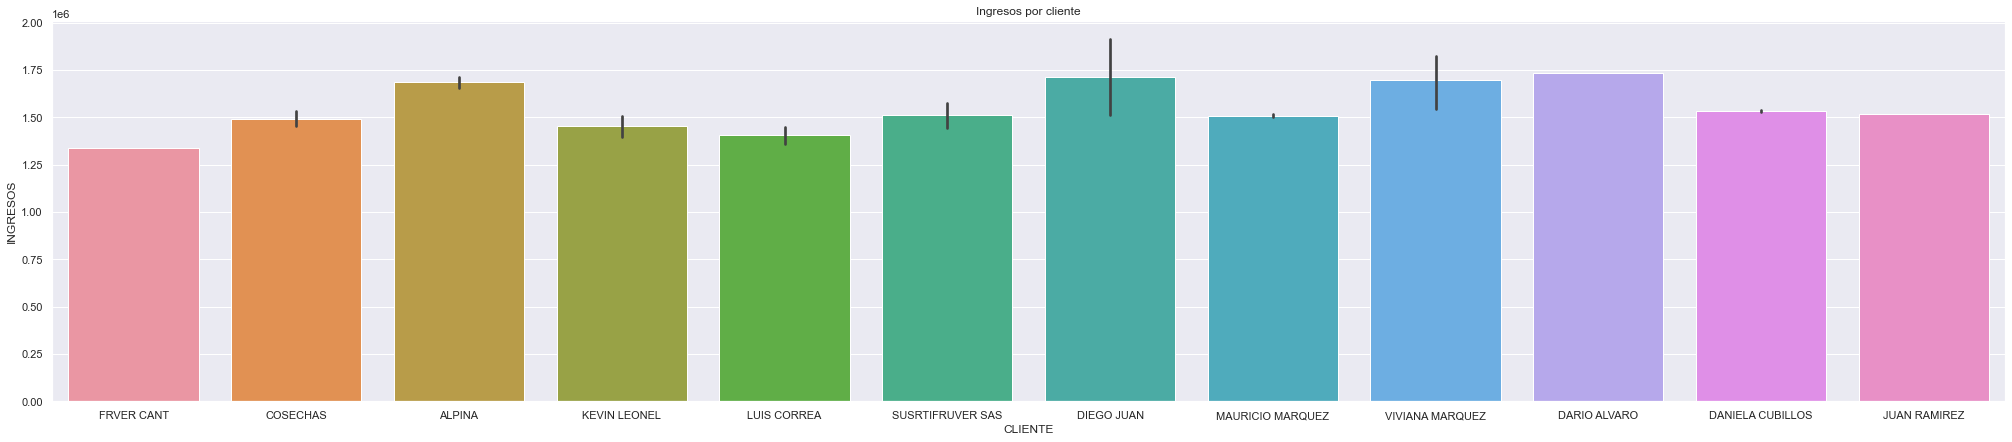

In [55]:
plt.figure(figsize=(35,7))
sns.barplot(x = 'CLIENTE',y='INGRESOS',data=data)
plt.title("Ingresos por cliente")
plt.show()

Los clientes que más generan ingresos para la empresa es alpina  y diana caldas, para aquellas personas que tengan mayores ingresos se les propone hacer un plan de fidelización con descuentos.

#### PRE PROCESAMIENTO

In [56]:
print(data.isnull().sum())
print('Dimension de los datos',data.shape)

FECHA                      0
INGRESOS                   0
PUBLICIDAD                 0
DIA SEM                    0
TEMPERATURA                0
ESTRATO SOCIO ECONÓMICO    0
PRODUCTO                   0
CLIENTE                    0
dtype: int64
Dimension de los datos (364, 8)


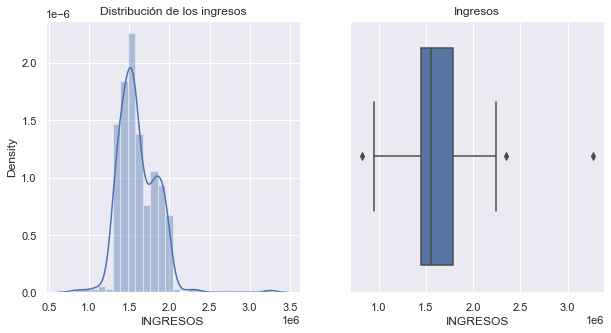

In [57]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(data['INGRESOS'])
plt.title("Distribución de los ingresos")
plt.subplot(1,2,2)
sns.boxplot(x='INGRESOS',data=data)
plt.title("Ingresos")
plt.show()

In [58]:
data[data.INGRESOS > 2300000] = np.nan
data[data.INGRESOS < 1000000] = np.nan
data.dropna(inplace=True)
data.head()

,FECHA,INGRESOS,PUBLICIDAD,DIA SEM,TEMPERATURA,ESTRATO SOCIO ECONÓMICO,PRODUCTO,CLIENTE
0,2021-01-01,1335781.0,59621.0,6.0,13.0,4.0,MERMELADA DE FRESA,FRVER CANT
1,2021-01-02,1414500.0,117485.0,7.0,21.0,4.0,MERMELADA DE FRESA,COSECHAS
2,2021-01-03,1466847.0,169105.0,1.0,23.0,4.0,SALSA DE TOMATE,ALPINA
3,2021-01-04,1496537.0,159214.0,2.0,20.0,4.0,SALSA DE TOMATE,ALPINA
4,2021-01-05,1456395.0,159873.0,3.0,21.0,4.0,HARINA DE GARBANZO,ALPINA


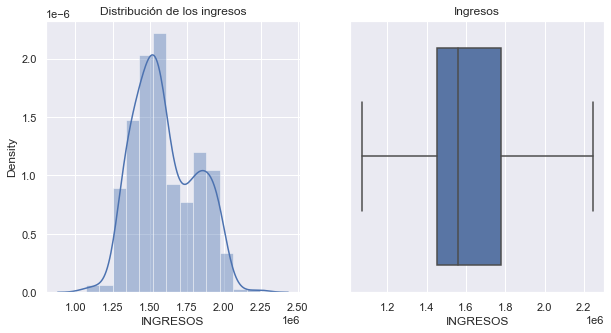

In [59]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(data['INGRESOS'])
plt.title("Distribución de los ingresos")
plt.subplot(1,2,2)
sns.boxplot(x='INGRESOS',data=data)
plt.title("Ingresos")
plt.show()

#### **PRIMER MODELO DE REGRESION**  
Inicialmente se propone hacer un modero de regresion simple con la variabe ingresos con el fin de determinar el niver de pubicidad.  
Se utilizan los modelos más simples de machine learning 

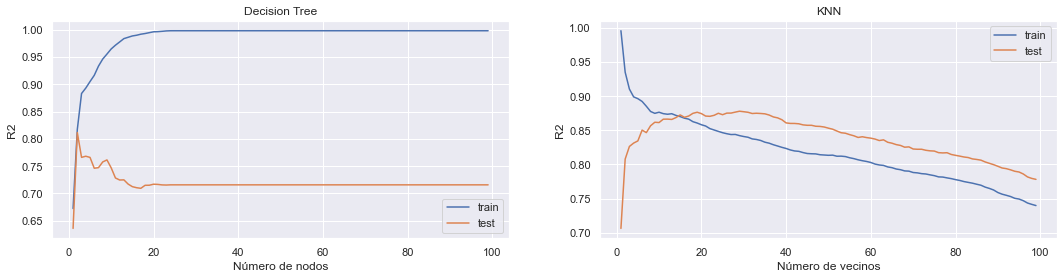

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
n = np.arange(1,100,1)
X_prim = data['PUBLICIDAD']
y_prim = data['INGRESOS']
X_train, x_test, y_train, y_test = train_test_split(X_prim, y_prim, test_size=0.2, random_state=0)

r2_tree_score_train = []
r2_tree_score_test = []

r2_knn_score_train = []
r2_knn_score_test = []

for a in n:

    Tree = DecisionTreeRegressor(max_depth =a)
    Tree.fit(np.array(X_train).reshape(-1, 1),y_train)
    tree_test_prede = Tree.predict(np.array(x_test).reshape(-1, 1))
    tree_train_prede = Tree.predict(np.array(X_train).reshape(-1, 1))
    r2_tree_score_train.append(r2_score(y_train,tree_train_prede))
    r2_tree_score_test.append(r2_score(y_test,tree_test_prede))

    KNN_t = KNeighborsRegressor(n_neighbors=a)
    KNN_t.fit(np.array(X_train).reshape(-1, 1),y_train)
    KNN_test_prede = KNN_t.predict(np.array(x_test).reshape(-1, 1))
    KNN_train_prede = KNN_t.predict(np.array(X_train).reshape(-1, 1))

    r2_knn_score_train.append(r2_score(y_train,KNN_train_prede))
    r2_knn_score_test.append(r2_score(y_test,KNN_test_prede))

lm =LinearRegression()
lm.fit(np.array(X_train).reshape(-1, 1),y_train)
lm_test_prede = lm.predict(np.array(x_test).reshape(-1, 1))
lm_train_prede = lm.predict(np.array(X_train).reshape(-1, 1))

plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
plt.plot(n,r2_tree_score_train,label='train')
plt.plot(n,r2_tree_score_test,label='test')
plt.xlabel('Número de nodos')
plt.ylabel('R2')
plt.title('Decision Tree')
plt.legend()
plt.subplot(1,2,2)
plt.plot(n,r2_knn_score_train,label='train')
plt.plot(n,r2_knn_score_test,label='test')
plt.xlabel('Número de vecinos')
plt.ylabel('R2')
plt.title('KNN')
plt.legend()
plt.show()

Se puede interpretar que los dos modelos generan resultados por alrededor de un 85% de r2, que los hacer ser relevantes. se pretenden hacer otras validaciones de regrecion para así obtar por el mejor primer modelo

Raíz del error cuadrático medio en Train: 1.0
Raíz del error cuadrático medio en Test: 0.8293752604422139


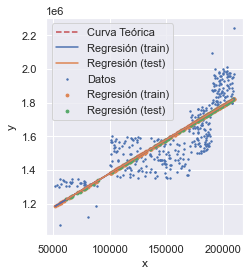

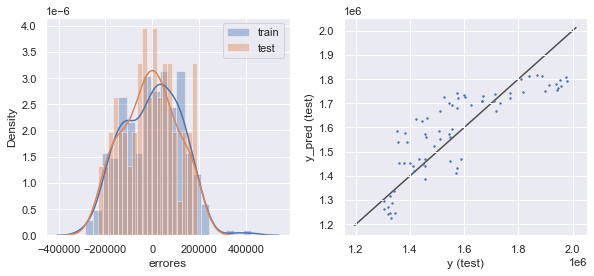

In [61]:
def evaluar_regresion(model,x,y, X_train, X_test, y_train, y_test):

    X_train = np.array(X_train).reshape(-1, 1)
    X_test = np.array(X_test).reshape(-1, 1)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    ### CALCULAMOS EL ERROR
    rmse_train = np.sqrt(r2_score(y_train_pred,y_train_pred))
    rmse_test = np.sqrt(r2_score(y_test, y_test_pred))

    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

    prede_y = model.predict(np.array(x).reshape(-1, 1))
    ### GRAFICAMOS LOS RESULTADOS
    plt.figure(figsize = (12,4))
    plt.subplot(1,3,1)
    plt.scatter(x,y, s = 2, label = 'Datos')
    plt.plot(x, prede_y, '--',label ='Curva Teórica', c = 'r')
    
    list1, list2 = zip(*sorted(zip(X_train[:,0], y_train_pred)))
    plt.plot(list1, list2,label ='Regresión (train)')
    
    list1, list2 = zip(*sorted(zip(X_test[:,0], y_test_pred)))
    plt.plot(list1, list2,label = 'Regresión (test)')

    
    plt.scatter(X_train[:,0],y_train_pred,label ='Regresión (train)', s = 8)
    plt.scatter(X_test[:,0],y_test_pred,label = 'Regresión (test)', s = 8)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

    plt.figure(figsize = (12,4))
    plt.subplot(1,3,2)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,3,3)
    ax.scatter(y_test,y_test_pred, s =2)

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

evaluar_regresion(lm,X_prim,y_prim, X_train, x_test, y_train, y_test)

Se observa que el modelo de regresion lineal muestra resultados optimos, auque muestra tambien sobreajuste en los datos de entrenamiento ya que en su funcion de costo tine un r2 de 1 y en los de testeo de 0.84, se pdrian aplicaar regularizazciones L1 y L2 al modelo para así mejorar su comportamiento.  
Los erroes tienen una distribución que se asemeja a a normal, sin embrago presenta errores aticpicos

Raíz del error cuadrático medio en Train: 1.0
Raíz del error cuadrático medio en Test: 0.8752847013076419


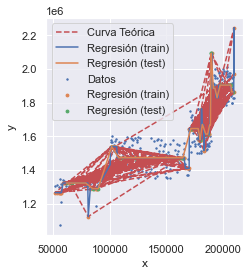

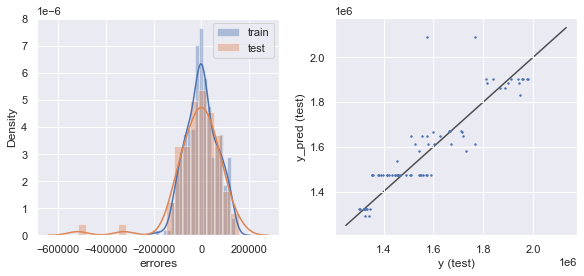

In [62]:

Tree = DecisionTreeRegressor(max_depth =5)
Tree.fit(np.array(X_train).reshape(-1, 1),y_train)
evaluar_regresion(Tree,X_prim,y_prim, X_train, x_test, y_train, y_test)

El modelo se ajusta mejor a los datos que la regresión lineal simple, tambien tiende a hacer overfiting, los errores tienden a la distribución normal y prediciendo nuevos datos generan un r2 de 0.87 que lo vuelve un modelo interesante

Raíz del error cuadrático medio en Train: 1.0
Raíz del error cuadrático medio en Test: 0.9201248020544278


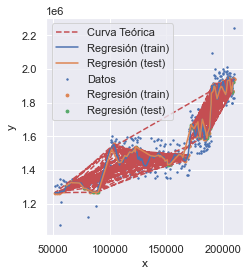

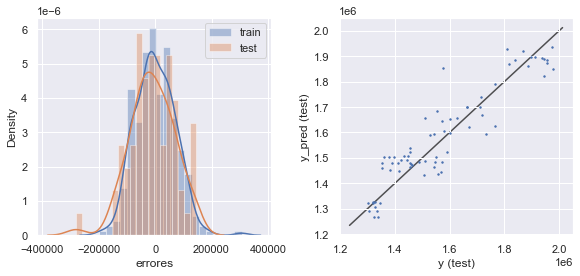

In [63]:
KNN_t = KNeighborsRegressor(n_neighbors=7)
KNN_t.fit(np.array(X_train).reshape(-1, 1),y_train)
evaluar_regresion(KNN_t,X_prim,y_prim, X_train, x_test, y_train, y_test)

El modelo KNN abarca la mayor cantidad de datos, contiene el R2 en los datos de testeo más alto de los anteriores dichos modelos, su distribución se asemeja más a la normal y es aquel modelo que se tendrá en cuenta para hacer una predicción.

#### Regresión multiple
> **PREPROCESAMIENTO DE DATOS**  
Inicialmente se piensa en que sería interesante transforma aquellas variables categoricas en numéricas, con el fin de tener más variables predictoras

In [64]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
producto = le.fit_transform(np.array(data.PRODUCTO))
one = OneHotEncoder()
one.fit(np.array(producto).reshape(-1, 1))
encoding = one.transform(np.array(producto).reshape(-1, 1)).toarray()
encoding = pd.DataFrame(encoding)
encoding.head(15)
data['mermelada_f'] = encoding[2]
data['salsa_t'] = encoding[3]
data['harina_g'] = encoding[0]
data['mantequilla_c'] = encoding[1]
df = data.drop(['PRODUCTO','FECHA','CLIENTE'], axis = 1)
df.head()

,INGRESOS,PUBLICIDAD,DIA SEM,TEMPERATURA,ESTRATO SOCIO ECONÓMICO,mermelada_f,salsa_t,harina_g,mantequilla_c
0,1335781.0,59621.0,6.0,13.0,4.0,1.0,0.0,0.0,0.0
1,1414500.0,117485.0,7.0,21.0,4.0,1.0,0.0,0.0,0.0
2,1466847.0,169105.0,1.0,23.0,4.0,0.0,1.0,0.0,0.0
3,1496537.0,159214.0,2.0,20.0,4.0,0.0,1.0,0.0,0.0
4,1456395.0,159873.0,3.0,21.0,4.0,0.0,0.0,1.0,0.0


Cuando se aplica un modelo de machine learning que tiene multiples variables, muchas veces se llegaa al error de que no estan n una misma medida, esto podría llegar a generar ruido en un modelo, es por eso que se sueleestandarizar, para así tener mejores resultados

In [65]:
from sklearn.preprocessing import MinMaxScaler
y = df['INGRESOS']
X = df.drop(['INGRESOS'], axis = 1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X = X.fillna(np.mean(X))
X.columns = ['publicidad','dia_sem','temperatura','estrato','mermelada_f','salsa_t','harina_g','mantequilla_c']

Inicialmente se graficaran los resultados de la regresión, y para tener mejores resultados se evaluara el modelo con random search, así para buscar el mejor hiperparametro del modelo y se evaluara con kfold cross validation, para no concurrien en el sobre ajuste del modelo

In [66]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import scipy as sp

X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

KNN = KNeighborsRegressor()

parametros_knn = {
    'n_neighbors': sp.stats.randint(1,50),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': sp.stats.randint(1,50),
    'p': sp.stats.randint(1,50),
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'mahalanobis', 'wminkowski', 'seuclidean', 'mahalanobis', 'canberra', 'braycurtis', 'yule', 'matching', 'dice', 'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'wminkowski']
}
knn_random = RandomizedSearchCV(KNN, parametros_knn,n_iter=500, random_state=0, cv=5)
knn_random.fit(X_train, y_train)



RandomizedSearchCV(cv=5, estimator=KNeighborsRegressor(), n_iter=500,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025DCAAFE2B0>,
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev',
                                                   'mahalanobis', 'wminkowski',
                                                   'seuclidean', 'mahalanobis',
                                                   'canberra', 'braycurtis',
                                                   'yule', 'matching', 'dice',
                                                   'kulsinski',
                                                   'rogerstanimoto',
                                                

In [67]:
print("Mejores parametros: "+str(knn_random.best_params_))
print("Mejor Score: "+str(knn_random.best_score_)+'\n')

Mejores parametros: {'algorithm': 'auto', 'leaf_size': 48, 'metric': 'euclidean', 'n_neighbors': 4, 'p': 4, 'weights': 'distance'}
Mejor Score: 0.6262210140893987



El modelo encontró los mejores parametros usando vecinos mas cercanos con un total de 0.61, se pretende entrenar el modelo y hacer cross validation para verificar sus resultados

In [68]:
KNN = KNeighborsRegressor(algorithm='auto',leaf_size=48,metric='euclidean',n_neighbors=4,p=4,weights='distance')
KNN.fit(X_train, y_train)
KNN_scores = cross_val_score(KNN, X, y, cv=5)
print(KNN_scores)
# print(tree_scores.mean(), knn_scores.mean())
print("Accuracy para KNN: %0.2f (+/- %0.2f)" % (KNN_scores.mean(), KNN_scores.std() * 2))
prede_test_KNN = KNN.predict(x_test)
prede_train_KNN = KNN.predict(X_train)
print('R2 para set de testeo',r2_score(y_test,prede_test_KNN))
print('R2 para set de entrenamiento',r2_score(y_train,prede_train_KNN))

[ 0.13822167 -0.05468484  0.65346297 -0.19506512 -0.31856178]
Accuracy para KNN: 0.04 (+/- 0.68)
R2 para set de testeo 0.6908542402056503
R2 para set de entrenamiento 1.0


Se puede observar que el modelo tiene al sobre ajuste ya que tiene r2 de 0.7 en el set de testeo y 1 en los datos de entrenamiento por lo cual, para futuros modelos se pretenden hacer regularizacion, descoposicion lineal y analisis de componentes proncipales, esto con el fin de mejorar los resultados del modelo

In [69]:
Tree = DecisionTreeRegressor()
parametros_tree = {
    'max_depth': sp.stats.randint(1,50),
    'min_samples_split': sp.stats.randint(2,50),
    'min_samples_leaf': sp.stats.randint(1,50),
    'min_weight_fraction_leaf': sp.stats.uniform(0,1),
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_leaf_nodes': sp.stats.randint(1,50),
    'min_impurity_decrease': sp.stats.uniform(0,1)}
tree_random = RandomizedSearchCV(Tree, parametros_tree,n_iter=500, random_state=0, cv=5)
tree_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=500,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025DCA2A6BB0>,
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025DCA2A6F70>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025DCA7D6790>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025DCA2A62E0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025DC9F2DB20>,
                                        'min_weight_fraction_leaf': <scipy.stats._distn_infrastructure.rv_

In [70]:
print("Mejores parametros: "+str(tree_random.best_params_))
print("Mejor Score: "+str(tree_random.best_score_)+'\n')

Mejores parametros: {'max_depth': 10, 'max_features': None, 'max_leaf_nodes': 36, 'min_impurity_decrease': 0.42600238766956056, 'min_samples_leaf': 19, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.033771567181470674}
Mejor Score: 0.8504435295126672



El arbol de desicion se ajusta más al set de datos con un puntaje de 0.85, de igual forma se confirmara con cross validation y el R2

In [71]:
Tree = DecisionTreeRegressor(max_depth=10, max_features = None, max_leaf_nodes = 36,
                            min_impurity_decrease =  0.42600238766956056, min_samples_leaf=19,min_samples_split=10
                            , min_weight_fraction_leaf= 0.033771567181470674)
Tree.fit(X_train, y_train)
Tree_scores = cross_val_score(Tree, X, y, cv=5)
print(Tree_scores)
print("Accuracy para Tree: %0.2f (+/- %0.2f)" % (Tree_scores.mean(), Tree_scores.std() * 2))
prede_test_Tree = Tree.predict(x_test)
prede_train_Tree = Tree.predict(X_train)
print('R2 para set de testeo',r2_score(y_test,prede_test_Tree))
print('R2 para set de entrenamiento',r2_score(y_train,prede_train_Tree))

[0.44567271 0.35434701 0.84461684 0.5791197  0.73989756]
Accuracy para Tree: 0.59 (+/- 0.36)
R2 para set de testeo 0.8499267778827257
R2 para set de entrenamiento 0.8794293019214896


Los arboles de desicion es el modelo que más se acomoda al set de datos sin generar ningun sobre ajuste y aun así tener un R2 tanto en los datos de entrenamiento como de teste generalizado y con un score alto.

In [72]:
lm = LinearRegression()
lm.fit(X_train, y_train)
lm_scores = cross_val_score(lm, X, y, cv=5)
print("Accuracy para regresion lineal: %0.2f (+/- %0.2f)" % (lm_scores.mean(), lm_scores.std() * 2))
prede_test_lm = lm.predict(x_test)
prede_train_lm = lm.predict(X_train)
print('R2 para set de testeo',r2_score(y_test,prede_test_lm))
print('R2 para set de entrenamiento',r2_score(y_train,prede_train_lm))

Accuracy para regresion lineal: -0.00 (+/- 1.01)
R2 para set de testeo 0.7133976325950706
R2 para set de entrenamiento 0.6735142546050638


El modelo de regresion lineal aunque genera resultado optimos, no tiene la suficiente complejidad para explicar el set de datos. cuenta con un R2 de para los datos de testeo de 0.71 lo cual indica qu no tiene sobre ajuste, cabe resaltar que el modelo tiene mayor acierto en los datos de testeo que de entramiento del modelo.  
Se usará el modelo de arboles de desicion para dar un respectivo analisis del comportamiento de las variables en la empresa

In [73]:

importance = Tree.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))


Feature: 0, Score: 0.92948
Feature: 1, Score: 0.00072
Feature: 2, Score: 0.06705
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00275


La variable publicidad es la que tiene mayor importncia y significacia en el modelo, esto puede interpretar que la variable ingresos de la compañia es más sensible a la publicidad

In [74]:
import random
dia_sem = []
for i in range(len(np.arange(100000,1000010,9166))):
    dia_sem.append(random.randint(1,7))

temperatura = np.arange(15,30,0.152)

estratos = []
for i in range(len(np.arange(15,30,0.153))):
    estratos.append(random.randint(3,5))

mermelada_f = []
for i in range(len(np.arange(15,30,0.153))):
    mermelada_f.append(0)


salsa_t = []
for i in range(len(np.arange(15,30,0.153))):
    salsa_t.append(0)

harina_g = []
for i in range(len(np.arange(15,30,0.153))):
    harina_g.append(0)

mantequilla_c = []
for i in range(len(np.arange(15,30,0.153))):
    mantequilla_c.append(1)

publicidad =np.arange(100000,1000010,9166)


publicidad = {'Publicidad':np.array(publicidad),'dia_sem':dia_sem,'temperatura':np.array(temperatura),'estratos':estratos,
                'mermelada_f': mermelada_f,'salsa_t':salsa_t,'harina_g':harina_g,'mantequilla_c':mantequilla_c}
publicidad = pd.DataFrame(publicidad)

ingresos = scaler.fit_transform(publicidad)
ingresos = pd.DataFrame(ingresos)
ingresos.columns = ['Publicidad','dia_sem','temperatura','estratos','mermelada_f','salsa_t','harina_g','mantequilla_c']
ingresos.head()

,Publicidad,dia_sem,temperatura,estratos,mermelada_f,salsa_t,harina_g,mantequilla_c
0,0.000000,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.010204,0.000000,0.010204,1.0,0.0,0.0,0.0,0.0
2,0.020408,0.166667,0.020408,0.5,0.0,0.0,0.0,0.0
3,0.030612,0.500000,0.030612,1.0,0.0,0.0,0.0,0.0
4,0.040816,0.833333,0.040816,1.0,0.0,0.0,0.0,0.0


Para poder aplicar nuevamente el modelo se debe hacer el mismo procedimientos en el preprocesamiento de los datos 

Predicciones de los ingreos por día 1925086.375
Valor medio de predicciones por día 1601821.5166666666
variacion de los ingresos 0.2018107853901451


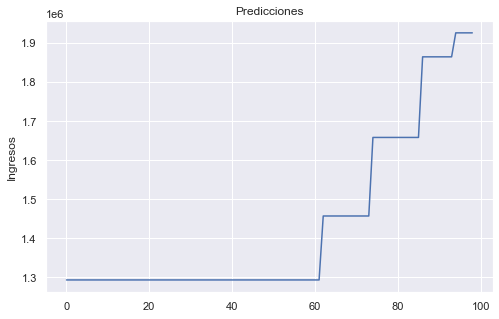

In [75]:
predicciones = Tree.predict(ingresos)

plt.figure(figsize=(8,5))
plt.plot(pd.DataFrame(predicciones))
plt.title('Predicciones')
plt.ylabel('Ingresos')
plt.show()
print('Predicciones de los ingreos por día',predicciones.max())
print('Valor medio de predicciones por día',np.mean(data.INGRESOS))
print('variacion de los ingresos',(predicciones.max()-np.mean(data.INGRESOS))/np.mean(data.INGRESOS))

Se observa un creciemiento hasta los 1.925.086, lo cual genera un crecimiento en los ingresos de un 20% para el proximo año, llega a un punto de publicidad en el cual tener mayor publicidad no genera mayores ingresos.

In [76]:
publicidad['predicciones'] = predicciones
mayor_ingreso =  publicidad[publicidad['predicciones'] == 1925086.375]
print('Promedio publicidad generadora del ingresos',mayor_ingreso.Publicidad.mean())
mayor_ingreso.head(10)

Promedio publicidad generadora del ingresos 979936.0


,Publicidad,dia_sem,temperatura,estratos,mermelada_f,salsa_t,harina_g,mantequilla_c,predicciones
94,961604,6,29.288,5,0,0,0,1,1925086.375
95,970770,4,29.440,4,0,0,0,1,1925086.375
96,979936,1,29.592,4,0,0,0,1,1925086.375
97,989102,5,29.744,4,0,0,0,1,1925086.375
98,998268,4,29.896,5,0,0,0,1,1925086.375


### CONCLUSIÓN  

En conclusion, producto estrella de la compañía, que genera más ingresos es la mantequilla de coco y así mismo debe tener una publicidad de 979.936 de este para máximizar los ingreos, la paerte de estratos esta distri,,su comportamiento de ingresos puede segruir creciendo con el paso del timpo, y aun más si se tiene evaluación constante de los datos cion los que cuente la empresa.